In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%pylab inline
from numpy import copy
import scipy as sp
from tqdm import tqdm
from time import time, sleep

Populating the interactive namespace from numpy and matplotlib


DISCLAIMER: проект находится сейчас в крайне нестабильной альфа-версии. Нижеприведенный код сходится далеко не при всех возможных параметрах. Это обусловлено тем, что алгоритм ADMM имеет четыре параметра, отвечающие за точность решения, и чтоб он не расходился, эти параметры должны находиться в каком-то нетривиальном (неустановленом пока) отношении. Под капотом стоят вручную заданные параметры такие, что при числе состояний от 5 до 10 и при числе девайсов от 10 до 300 оно __вроде бы__ не падает. На моем маке он строит график в среднем за минуту. Если алгоритм работает крайне долго и не завершается -- нужно останавливать ядро. Если он падает -- нужно слегка поварьировать входные параметры.

100%|██████████| 200/200 [00:49<00:00,  4.05it/s]


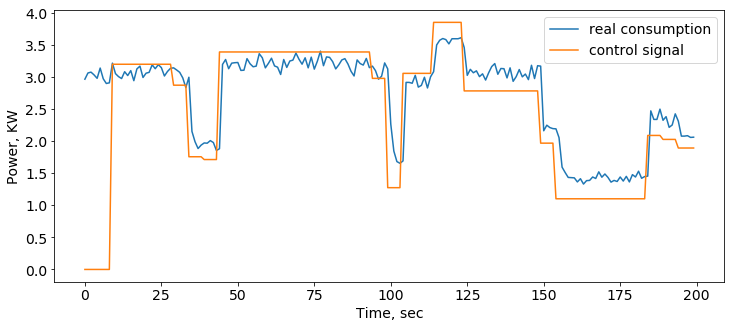

In [16]:
from Ensemble import AbstractEnsemble
from main import solve
from scipy.optimize import minimize


# Здесь находятся параметры, которые можно менять

# K -- число девайсов. Чем их больше -- тем плавнее выглядит график, но тем сильнее нагружается 
# ядро OC. На практике, контроль дает адекватную картинку даже при малом числе девайсов (5-10).
# Для "дерганного" графика рекомендую K = 10, для "плавного" K = 300. Осторожно: каждый девайс 
# существует в отдельном потоке, поэтому при K = 400 машина рискует зависнуть и потребовать
# перезагрузки
K = 300 
# N -- число состояний. Не тестировалось больше, чем на 50 состояниях. Рекомендую оставить 5-6. 
N = 5
# q -- вектор стоимости состояний. Сейчас первое состояние стоит 1, второе -- 2 и тд
q = (arange(N) + 1).reshape((N, 1))
# random_seed определяет форму кривой требуемой энергии. Не нравится текущая -- смени random_seed. 
random_seed = 42
# T -- периодичность, с которой нам приходят запросы на требуемое потребление (каждые T тактов)
T = 5
# jump_probability определяет вероятность, с которой каждые T тактов приходит 
# запрос на новый уровень энергии. 0 -- константный запрос, 1 -- скачет каждые T тактов
jump_probability = 1/3
# time_limit -- число тактов, которые работает система. Чем больше -- тем дольше работает.
time_limit = 200


#ниже -- блок кода, который трогать не надо
np.random.seed(random_seed)

ensemble = AbstractEnsemble(K, default_policy = ones((N, N))/N, tick=0.01, random_seed=random_seed)
states = []
consumption = []
ss = []
sol = []
us = []
pn = []
sn = []
s = 0

def c(t):
    return 1

def find_pi_new(pi_old, q, s):
    n = len(q)
    f = lambda x: norm(x - pi_old)**2
    cons = [{"type": "eq", "fun": lambda x: x.dot(q) - s},
            {"type": "eq", "fun": lambda x: x.dot(ones(n)) - 1}]
    bnds = [(0, None) for _ in range(n)]
    res = minimize(f, pi_old, method='SLSQP', bounds=bnds, constraints=tuple(cons))
    return res.x.reshape((n, 1))
    
try:
    ensemble.run()

    for i in tqdm(range(1,time_limit+1)):
        sleep(0.02)
        if i % T == 0 and rand() > 1-jump_probability:
            s = 1+ rand()*(N-2)
            u = states[-1]
            pi_new = find_pi_new(u, q, s)
            #print(c(i), u, s, pi_new, q)
            begin = time()
            us.append(u)
            pn.append(pi_new)
            sn.append(s)
            P, log, converged = solve(c(i), u, s, pi_new, q)
            end = time()
            sol.append(end-begin)
            ensemble.change_policy(P)
        ss.append(s)
        states.append(copy(ensemble.get_state_distribution().reshape((N, 1))))
        states[-1] /= sum(states[-1])
        consumption.append(q.T.dot(states[-1]))
finally:     
    ensemble.stop()
    
    
# ниже -- блок кода, который отвечает за рисование графика. 
matplotlib.rcParams.update({"font.size":14})
figure(figsize=(12, 5))
plot([x[0, 0] for x in consumption], label="real consumption")
plot(ss, label="control signal")
xlabel("Time, sec")
ylabel("Power, KW")
legend()